# Creating a Stepped Log Scale ColorBar
## Introduction

This Notebook is a re-implenentation of some of the maps relating to livestock, based upon the book Python Maps
Geospatial Visualization with Python, 
by Adam Symington [https://locatepress.com/book/pymaps]

I found the book excellent.  I was already familiar with GeoPandas, but the book covers other packages, such as `rasterio`. 

However, this post is more about a challenge I set myself to improve my understanding of `matplotlib` color maps, colorbars, and color-related normalization.  The original graphic showed cattle density globally, on a log scale  because of the great range of cattle density globlly, using a color map (and colorbar) that appeared to smoothly change from one color to another as density increased.  I wanted a color map (and a colorbar) where the color was the same from one colorbar tick mark to the next, but jumped discretely at tick mark divisions.  Furthermore, I wanted to be able to automatically create the new colorbar.

I'll defer discussion of the main concepts (as I understand them) to below.

----------------------
## Implementation
### Notebook magic commands

- watermark provides reproducability information
- lab_black formats cells automatically

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

### Notebook imports

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib
from matplotlib.ticker import StrMethodFormatter

import rasterio
from rasterio.plot import show

--------------------
## Data Load

We us `rasterio` to load the `TIF` file.  We examine the Coordinate Reference System (CRS) used for this dataset.  Good old EPSG:4326, or Plate Carree.  For our purposes, this is a good enough projection to use for global maps, so we don't need to use Cartopy for any CRS changes.

In [4]:
CATTLE_URL = "C:\\Data\\PythonMaps\\Livestock\\GLW4-2020.D-DA.CTL.tif"

cattle = rasterio.open(CATTLE_URL)

print(
    cattle.crs,
)

EPSG:4326


We now read the data into an array.  We plan to use `imshow` (and not `rasterio.show`) we we must convert any bad-data values for that used by `rasterio` to that used by `numpy`

In [5]:
array = cattle.read(1)
array[array == (cattle.nodata)] = np.nan

--------------
### Color concepts

The general idea is that we have a Normalization function, that specifies how to take a data value, and squash it down to a value that can be used to look up a color.  A LogNorm Normalization class squashes the ranges of data values between 1-10 and 10-100, into equal ranges for looking up colors.

A Colormap is a class that takes a normalized value, and gives back a color (R,G,B,Alpha).  `Matplotlib` says graphic applications will 
>make heavy use of this data -> normalize -> map-to-color processing chain.

So when we call `imshow` (for example), we have to tell `imshow` first how to normalize the data for color lookup, and secondly specify the color map map to use to map a normalized data value into a color.

### Tick mark concepts
#### Locators
`matplotlib` has the concept of a `tick locator`, which is the object that when given a range (and other constraints) will find the "nicest" values in that range to place tick marks.  **Major** tick values will get a label and a tick, **minor** ticks values just get a tick.  For example, for Log scales, the tick locator is called `LogLocator`.

#### Tick formatters
Tick formatters define how the numeric value associated with a tick on an axis is formatted as a string.  For example, to specify tick mark labels as integers with comma seperators, use `StrMethodFormatter('{x:,.0f}')`, where we use `f string` format string capabilities.

### Color concept example

So in the code below, we first specify that we are intered in data values between 5 and 5000, and we want a log scale on the colorbar (e.g. 10-100 and 100-1000 occupy the same fraction of the colorbar)

We also specify that we want of the pre-defined color ranges (Yellow to Orange to Brown)

We also specify that any bad data values show be shown as black, and data values under the minimum should also be shown as black

In [6]:
cattle_norm = colors.LogNorm(vmin=5, vmax=5000)
cattle_cmap = matplotlib.colormaps['YlOrBr']
cattle_cmap.set_bad(color='black')
cattle_cmap.set_under('black')

Now we use `imshow`  to display global cattle density.  Making the background black makes for a dramatic graphic.  A couple of points to note:

* I could have feed the results of the `imshow` call into the `colorbar` call, but choose to input the colorm ap and norm explicitly

* The results of the`imshow` call is something called a `ScalarMappable`, which I think is a very unhelpful name.  Essentially (from the code):

>     The ScalarMappable applies data normalization before returning RGBA colors from  the given `~matplotlib.colors.Colormap`.

* In my experience, colorbars are too big by default, so I usually choose to shrink them

* By default, `LogNorm` colorbars use major tick labels that are shown as powers of 10.  This is best for where there are many orders of magnitude beteen the minimum and maximum values.  For cases (like this one) with a smaller range, I prefer to have explicit integers.

* The colorbar makes a smooth color transition between minimum and maximum values.


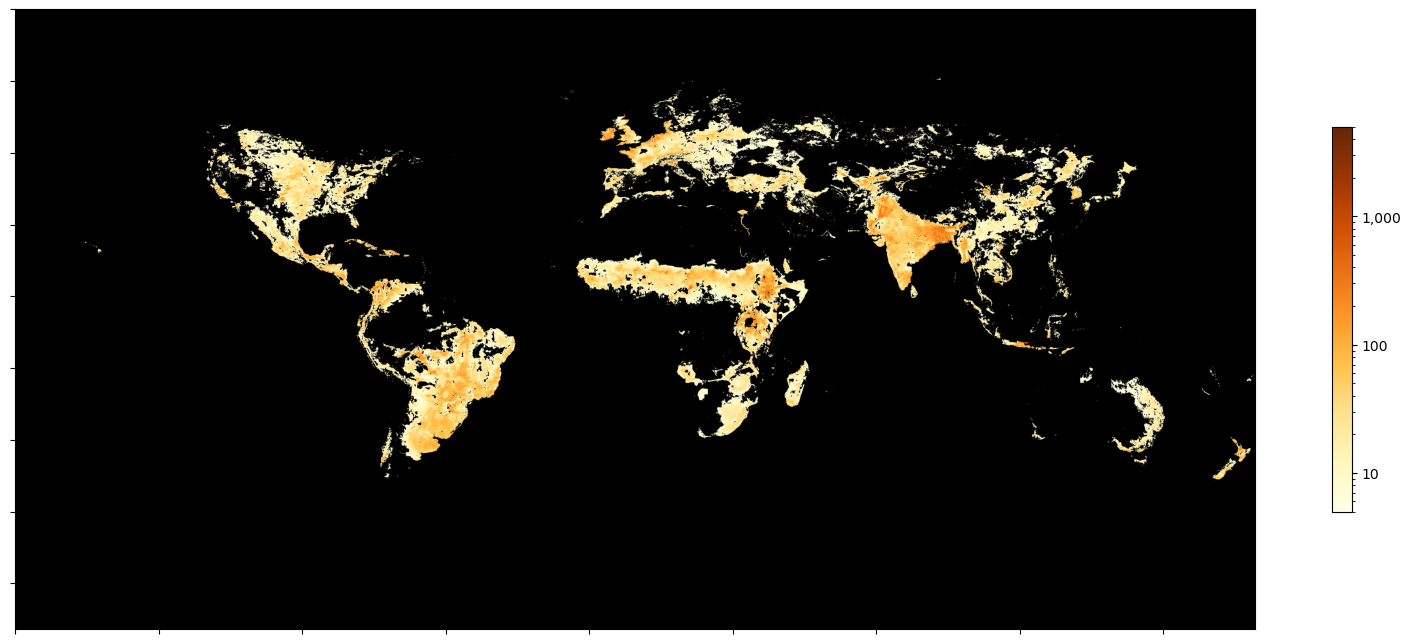

In [7]:
fig, ax = plt.subplots(
    figsize=(20, 20),
)

# make background black
ax.patch.set_facecolor('black')


# display our data array, using our chosen colormap and normalization
pcm = ax.imshow(
    array,
    cmap=cattle_cmap,
    norm=cattle_norm,
    alpha=1,
)

# draw a colorbar.  We could supply pcm as object that we want a colorbar for
# but chose to pass colormap and normalization objects in explicitly
cb = fig.colorbar(
    None,
    cmap=cattle_cmap,
    norm=cattle_norm,
    ax=ax,
    extend=None,
    shrink=0.25,
)

# turn off array index labels to unclutter the chart
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

# have colorbar labels as integers (not powers)
cb.formatter = StrMethodFormatter('{x:,.0f}')

-------------------------------
### Colorbar construction

Below is a helper function that takes an existing color map (assumed to be smooth) and a value range, and returns a color map and Norm object that can be used to create a colorbar where the color _jumps_ at the tick marks.  Because I want to faithfully mimic a default smooth colorbar with a Log scale, I also have to return the data values where the major tick mark labels go.

In [8]:
def get_step_colormap(
    vmin: float,
    vmax: float,
    cmap: matplotlib.colors.Colormap,
):
    '''
    get_step_colormap: given value range and colormap,
                    generate a ListedColormap and BoundaryNorm to mimic default Log scale colorbar

    Parameters:
    vmin: float/ integer - minimum value to appear on colorbar
    vmax: float/ integer - maximum value to appear on colorbar
    cmap: matplotlib colormap, to be used in Log scale colorbar

    Returns:
    tuple
    step_cmap, step_norm, major_ticks
    where:
    step_map is a colormap that changes color in steps (rather than a smooth gradient),
            where the color matches the input colorbar at tick mark data values
    step_norm is a BoundaryNorm that maps  data values to the  input colobar color at tick data values
    major_ticks is an array of data values to show where colorbar labels are to be drawn


    Assumes the following imports
    import matplotlib
    from matplotlib import colors
    '''

    # get all log scale tick marks for our vmin-vmax range
    # it appears generated tick marks can lie outside max and min values of norm
    # so we filter out those outside max and min values
    ticks = [
        t
        for t in matplotlib.ticker.LogLocator(
            subs='all',
        ).tick_values(vmin, vmax)
        if t >= vmin and t <= vmax
    ]

    # get major ticks where labels will go
    # we choose to glue max and min to this list
    major_ticks = (
        [vmin]
        + [
            t
            for t in matplotlib.ticker.LogLocator().tick_values(
                vmin, vmax
            )
            if (t >= vmin) and (t <= vmax)
        ]
        + [vmax]
    )

    # get the lookup value (0-1) to get the color at each tick mark
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    norm_ticks = [norm(t) for t in ticks]

    # get the colors at each tick mark
    cb_colors = [cmap(n) for n in norm_ticks]

    # create a colormap that has the colors desired at each of the tick labels
    step_cmap = colors.ListedColormap(cb_colors)

    # create a Norm that maps tick data values to the desired color at each tick
    step_bounds = ticks
    step_norm = colors.BoundaryNorm(
        step_bounds, step_cmap.N
    )

    return (step_cmap, step_norm, major_ticks)


# end get_step_colormap

-------------
### Creating a discrete colorbar

Note that this second colorbar has labels at minimum and maximum (my choice - I don't know why the `matplotlib` algorithm for lable placement doesn't do this).  I have doubled the colorbar size.

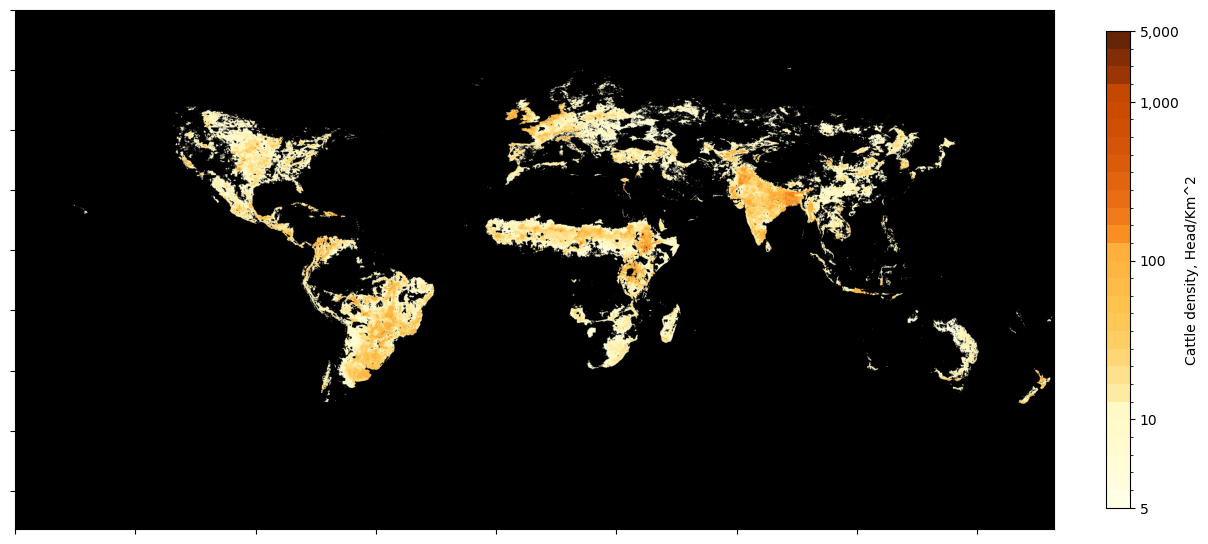

In [9]:
fig, ax = plt.subplots(
    figsize=(12, 12), layout='constrained'
)

ax.patch.set_facecolor('black')

# get the colormap, and Norm object to be used to create new colorbar
step_cmap, step_norm, major_ticks = get_step_colormap(
    5, 5000, cattle_cmap
)

# as before set bad, and under-minimum values to black
step_cmap.set_bad(color='black')
step_cmap.set_under('black')

# show the array
pcm = ax.imshow(
    array,
    cmap=step_cmap,
    norm=step_norm,
    alpha=1,
)

# unclutter the chart
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

# create a new  colorbar. We have chosen to create a ScalarMappable object
# as a way of specifying our colormap and Norm
step_cb = fig.colorbar(
    cm.ScalarMappable(cmap=step_cmap, norm=step_norm),
    ax=ax,
    orientation='vertical',
    label='Cattle density, Head/Km^2',
    shrink=0.4,
)

# override new colorbar default label positions
_ = step_cb.long_axis.set_ticks(major_ticks)

# have colorbar labels as integers (not powers)
step_cb.formatter = StrMethodFormatter('{x:,.0f}')

Another view of the colormap we have created

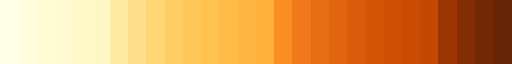

In [10]:
step_cmap

-----------------

## Conclusion

As always, a careful study of the `matplotlib` underlying concepts allows almost unlimited tailoring of the resulting graphics.

-------------------
## Reproducibility

### Notebook version status

In [12]:
%watermark

Last updated: 2025-04-28T13:17:52.383107+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [13]:
%watermark -co  -iv -v -h

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

conda environment: pythonmaps

Hostname: INSPIRON16

matplotlib: 3.10.0
rasterio  : 1.4.3
numpy     : 1.26.4

